In [1]:
import tensorflow as tf
import keras
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import typing

In [2]:
NUM_INPUT_FEATURES = 4

## Helper Functions

In [3]:

def plot_multiple_histories(histories : typing.Dict, metric='loss', use_greyscale=True, show_validation=False, sort_agg_func=np.mean, sort_history_length=2, *args, **kwargs):
  """
  Plots the training history of multiple models on the same plot for comparison.

  Parameters:
    histories: List of History objects from multiple model's fit() calls.
    metric: The metric to plot ('loss', 'accuracy', etc.).
    labels: List of labels for the models. If None, defaults to 'Model 1', 'Model 2', etc.
  """
  # Check if labels are provided, otherwise generate default labels
  # if labels is None:
  #   labels = [f'Model {i+1}' for i in range(len(histories))]

  # Initialize the plot
  plt.figure(figsize=(10, 6))

  norm = plt.Normalize(vmin=0, vmax=len(histories))
  grayscale_cmap = plt.colormaps['gray']

  sorted_keys = sorted(histories.keys(), key=(lambda k: sort_agg_func(histories[k].history[metric][:-sort_history_length])))
  for i, label in enumerate(sorted_keys):
    history = histories[label]
    #for i, (label, history) in enumerate(histories.items()):
    epochs = range(1, len(history.history[metric]) + 1)

    # Plot training metric
    plt.plot(epochs, history.history[metric], label=f'{label} {metric.capitalize()}', color=grayscale_cmap(norm(i)))

    # Plot validation metric if available
    if show_validation and f'val_{metric}' in history.history:
      plt.plot(epochs, history.history[f'val_{metric}'], '--', label=f'{label} Validation {metric.capitalize()}', color=grayscale_cmap(norm(i)))

  # Add labels and title
  plt.title(f'Comparison of {metric.capitalize()} Between Models')
  plt.xlabel('Epochs')
  plt.ylabel(metric.capitalize())
  plt.legend()

  # Show plot
  plt.show()


In [4]:
def make_data(
    num_samples=1000,
    num_input_features=10,
    informative_features=2,   # how many features actually matter
    n_classes=2,
    test_size=0.33,
    random_state=42,
    clusters_per_class=1,     # keep 1 to avoid the common constraint error
    class_sep=1.0,
    flip_y=0.0
):
    """
    Generate simple classification data and return train/test splits.

    Args:
        num_samples: total samples to generate.
        num_input_features: total feature columns in X.
        informative_features: number of informative features (<= num_input_features).
        n_classes: number of classes (2 for binary).
        test_size: fraction for test split.
        random_state: RNG seed for reproducibility.
        clusters_per_class: clusters per class (keep 1 for simplicity).
        class_sep: class separability (larger => easier).
        flip_y: label noise fraction.

    Returns:
        X_train, X_test, y_train, y_test
    """
    X, y = sklearn.datasets.make_classification(
        n_samples=num_samples,
        n_features=num_input_features,
        n_informative=informative_features,
        n_redundant=0,
        n_repeated=0,
        n_classes=n_classes,
        n_clusters_per_class=clusters_per_class,
        class_sep=class_sep,
        flip_y=flip_y,
        shuffle=True,
        random_state=random_state,
    )

    return sklearn.model_selection.train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )


## Our Functions

In [16]:
def make_binary_classification_model(
    num_input_features=NUM_INPUT_FEATURES,
    num_hidden_layers=0,
    activation='relu'
):
    model = keras.models.Sequential()
    model.add(
        keras.layers.Input(
            shape=(num_input_features,)
        )
    )

    # Add hidden layers
    for _ in range(num_hidden_layers):
        model.add(
            keras.layers.Dense(2, activation=activation)
        )

    # Output layer
    model.add(
        keras.layers.Dense(1, activation='sigmoid')
    )

    return model

In [22]:
def train_model(
    model: keras.Model, 
    X_train, 
    y_train, 
    loss_func='binary_crossentropy', 
    *args, **kwargs
):
  model.compile(
    optimizer='SGD',
    loss=loss_func,
    metrics=['accuracy']
  )
  history = model.fit(
    X_train, y_train,
    batch_size=kwargs.get("batch_size", 32),
    epochs=kwargs.get("num_epochs", 40),
    validation_split=0.3,
    verbose=0
  )
  return history

## Our Flow

### Take 1: A simple model

In [7]:
make_binary_classification_model(num_hidden_layers=0).summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (20.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
make_binary_classification_model(num_hidden_layers=1).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
make_binary_classification_model(num_hidden_layers=2).summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369 (1.44 KB)

 Trainable params: 369 (1.44 KB)

 Non-trainable params: 0 (0.00 B)

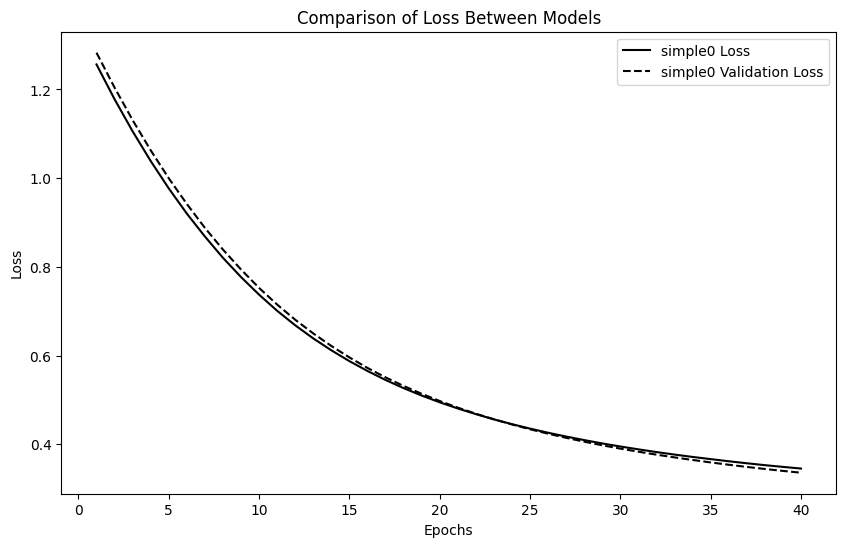

In [13]:
(X_train, X_test, y_train, y_test) = make_data(num_input_features=NUM_INPUT_FEATURES)

plot_multiple_histories(
  {
    "simple0": train_model(make_binary_classification_model(), X_train, y_train),
  },
    show_validation=True
)

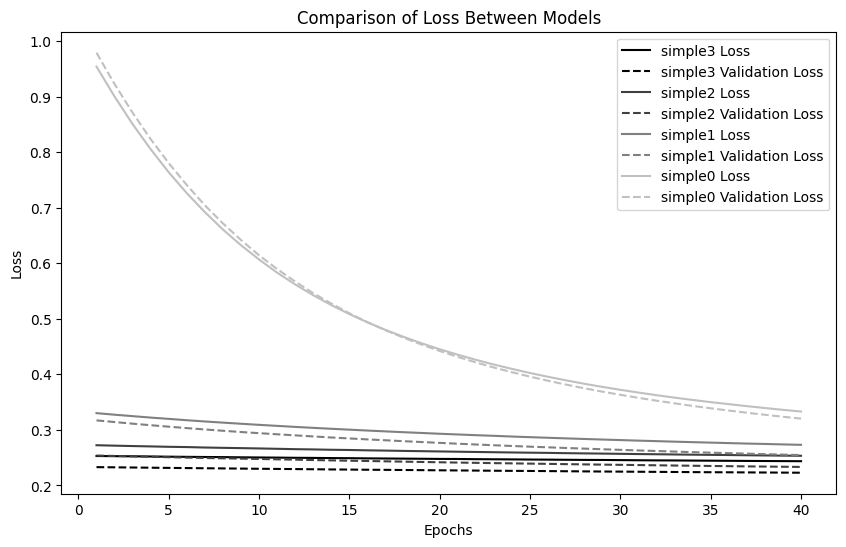

In [14]:
(X_train, X_test, y_train, y_test) = make_data(num_input_features=NUM_INPUT_FEATURES)

model_to_train = make_binary_classification_model()
plot_multiple_histories(
  {
    "simple0": train_model(model_to_train, X_train, y_train),
    "simple1": train_model(model_to_train, X_train, y_train),
    "simple2": train_model(model_to_train, X_train, y_train),
    "simple3": train_model(model_to_train, X_train, y_train),
  },
    show_validation=True
)

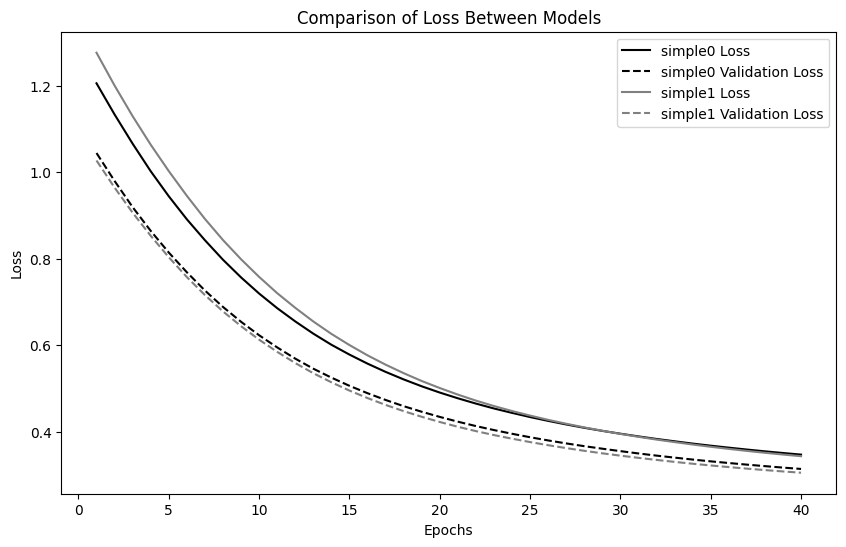

In [15]:
(X_train, X_test, y_train, y_test) = make_data(num_input_features=NUM_INPUT_FEATURES)

plot_multiple_histories(
  {
    "simple0": train_model(make_binary_classification_model(), X_train, y_train),
    "simple1": train_model(make_binary_classification_model(), X_train, y_train),
  },
    show_validation=True
)

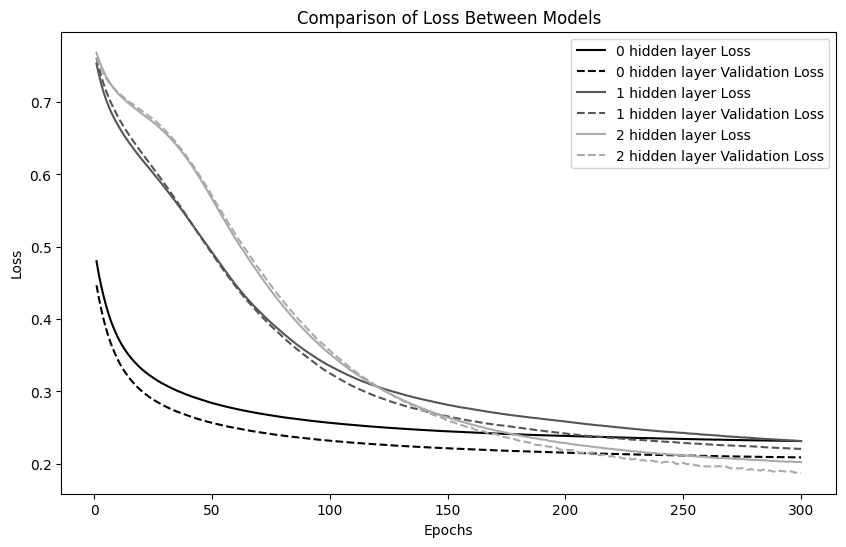

In [27]:

kwargs_to_pass = {
    "num_input_features": NUM_INPUT_FEATURES,
    "num_hidden_layers" : 0,
    "activation": 'relu'
}

NUM_EPOCHS = 300

plot_multiple_histories(
  {
    "0 hidden layer": train_model(
        make_binary_classification_model(num_hidden_layers=0), X_train, y_train, num_epochs=NUM_EPOCHS),
    "1 hidden layer": train_model(
        make_binary_classification_model(num_hidden_layers=1),  X_train, y_train, num_epochs=NUM_EPOCHS),
    "2 hidden layer": train_model(
        make_binary_classification_model(num_hidden_layers=2),  X_train, y_train, num_epochs=NUM_EPOCHS),
  },
    show_validation=True
)

In [26]:
make_binary_classification_model(num_hidden_layers=0).summary()
make_binary_classification_model(num_hidden_layers=1).summary()
make_binary_classification_model(num_hidden_layers=2).summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (20.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (76.00 B)

 Trainable params: 19 (76.00 B)

 Non-trainable params: 0 (0.00 B)

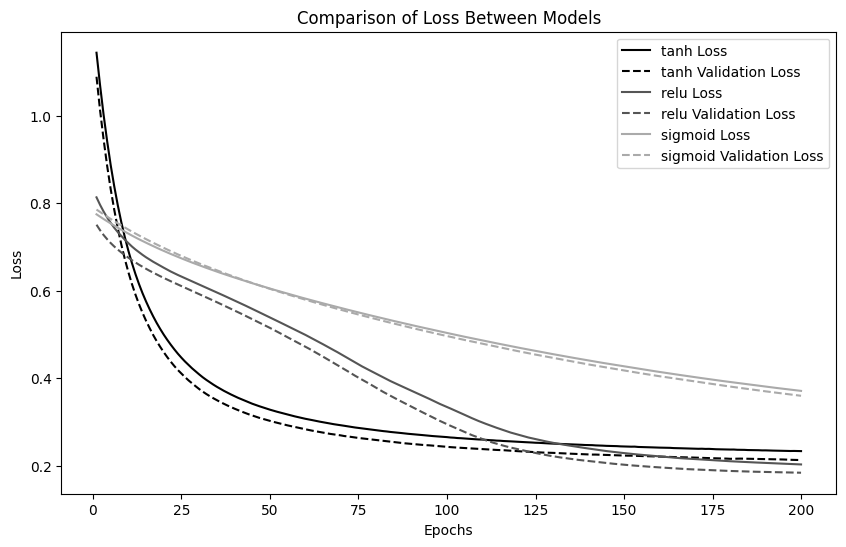

In [31]:

kwargs_to_pass = {
    "num_input_features": NUM_INPUT_FEATURES,
    "num_hidden_layers" : 0,
    "activation": 'relu'
}

NUM_EPOCHS = 200

plot_multiple_histories(
  {
    "relu": train_model(
        make_binary_classification_model(num_hidden_layers=1, activation="relu"), X_train, y_train, num_epochs=NUM_EPOCHS),
    "sigmoid": train_model(
        make_binary_classification_model(num_hidden_layers=1, activation="sigmoid"), X_train, y_train, num_epochs=NUM_EPOCHS),
    "tanh": train_model(
        make_binary_classification_model(num_hidden_layers=1, activation="tanh"), X_train, y_train, num_epochs=NUM_EPOCHS),
  },
    show_validation=True
)

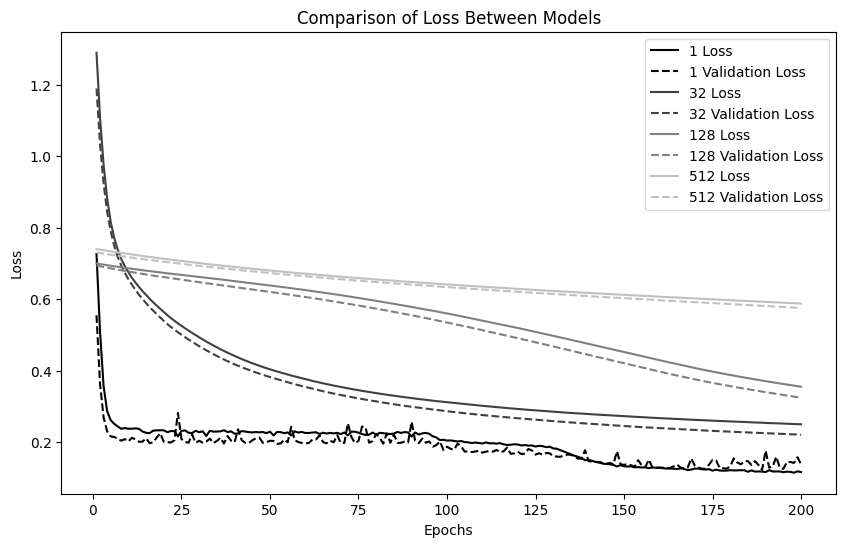

In [32]:

kwargs_to_pass = {
    "num_input_features": NUM_INPUT_FEATURES,
    "num_hidden_layers" : 0,
    "activation": 'relu'
}

NUM_EPOCHS = 200

plot_multiple_histories(
  {
    "1": train_model(
        make_binary_classification_model(num_hidden_layers=1, activation="relu"), X_train, y_train, num_epochs=NUM_EPOCHS, batch_size=1),
    "32": train_model(
        make_binary_classification_model(num_hidden_layers=1, activation="relu"), X_train, y_train, num_epochs=NUM_EPOCHS, batch_size=32),
    "128": train_model(
        make_binary_classification_model(num_hidden_layers=1, activation="relu"), X_train, y_train, num_epochs=NUM_EPOCHS, batch_size=128),
    "512": train_model(
        make_binary_classification_model(num_hidden_layers=1, activation="relu"), X_train, y_train, num_epochs=NUM_EPOCHS, batch_size=512),
  },
    show_validation=True
)